In [112]:
%matplotlib inline
from __future__ import division, print_function

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import STUDENT
import gc_colors
import pandas as pd
import glob
import re
import os 
import TBFunctions as TB
import danplotlib as dpl
import numpy as np
from itertools import izip
from uncertainties import ufloat, unumpy

reload(TB)

plt.style.use("latex")
gc_colors.update_colorcycle()

# List all available files

In [2]:
DF_all_files = TB.Files_DF("/auto/data/berninghoff/tb2017_1_Output/Preselection/*/*.root")
DF_all_files.iloc[:,:0:-1]

Filename_short  Position  ThSetting  IntSetting  \
0  2.0GeV_setting4.2_000mm_1_noComment.root         0          2           4   
1  2.0GeV_setting4.1_000mm_1_noComment.root         0          1           4   
2  2.0GeV_setting4.3_000mm_1_noComment.root         0          3           4   

   Beamenergy  Layer  
0         2.0      0  
1         2.0      0  
2         2.0      0

# Choose subset of files and read in data

In [3]:
settings = { "Layer" : [0],
             "Beamenergy" : [2.0], #GeV
             "Position" : [0], #mm
             "IntSetting" : [4],
             "ThSetting" : [1,2,3],
             "inFilename" : "1_noComment"}

DF_selected_files = TB.filter_files(DF_all_files, settings)
DF_selected_files = TB.read_data(DF_selected_files)
DF_selected_files

Reading in data from  /auto/data/berninghoff/tb2017_1_Output/Preselection/Layer_0/tb2017_1_pacific_2.0GeV_setting4.2_000mm_1_noComment.root
Found clusterfiles:  ['/auto/data/berninghoff/tb2017_1_Output/Preselection/Layer_0/Clusters/Default/tb2017_1_pacific_2.0GeV_setting4.2_000mm_1_noComment.h5', '/auto/data/berninghoff/tb2017_1_Output/Preselection/Layer_0/Clusters/No_requirements/tb2017_1_pacific_2.0GeV_setting4.2_000mm_1_noComment.h5', '/auto/data/berninghoff/tb2017_1_Output/Preselection/Layer_0/Clusters/Big/tb2017_1_pacific_2.0GeV_setting4.2_000mm_1_noComment.h5', '/auto/data/berninghoff/tb2017_1_Output/Preselection/Layer_0/Clusters/Seed_1/tb2017_1_pacific_2.0GeV_setting4.2_000mm_1_noComment.h5']
Reading in data from  /auto/data/berninghoff/tb2017_1_Output/Preselection/Layer_0/tb2017_1_pacific_2.0GeV_setting4.1_000mm_1_noComment.root
Found clusterfiles:  ['/auto/data/berninghoff/tb2017_1_Output/Preselection/Layer_0/Clusters/Default/tb2017_1_pacific_2.0GeV_setting4.1_000mm_1_noCommen

Filename  Layer  Beamenergy  \
0  /auto/data/berninghoff/tb2017_1_Output/Presele...      0         2.0   
1  /auto/data/berninghoff/tb2017_1_Output/Presele...      0         2.0   
2  /auto/data/berninghoff/tb2017_1_Output/Presele...      0         2.0   

   IntSetting  ThSetting  Position                            Filename_short  \
0           4          2         0  2.0GeV_setting4.2_000mm_1_noComment.root   
1           4          1         0  2.0GeV_setting4.1_000mm_1_noComment.root   
2           4          3         0  2.0GeV_setting4.3_000mm_1_noComment.root   

                                           Dataframe  
0           Evt_num     Run_num    Timestamp  Lay...  
1           Evt_num     Run_num   Timestamp  Laye...  
2           Evt_num     Run_num    Timestamp  Lay...

# Plot aggregated Signalshape over a certain channel range

 58 59]


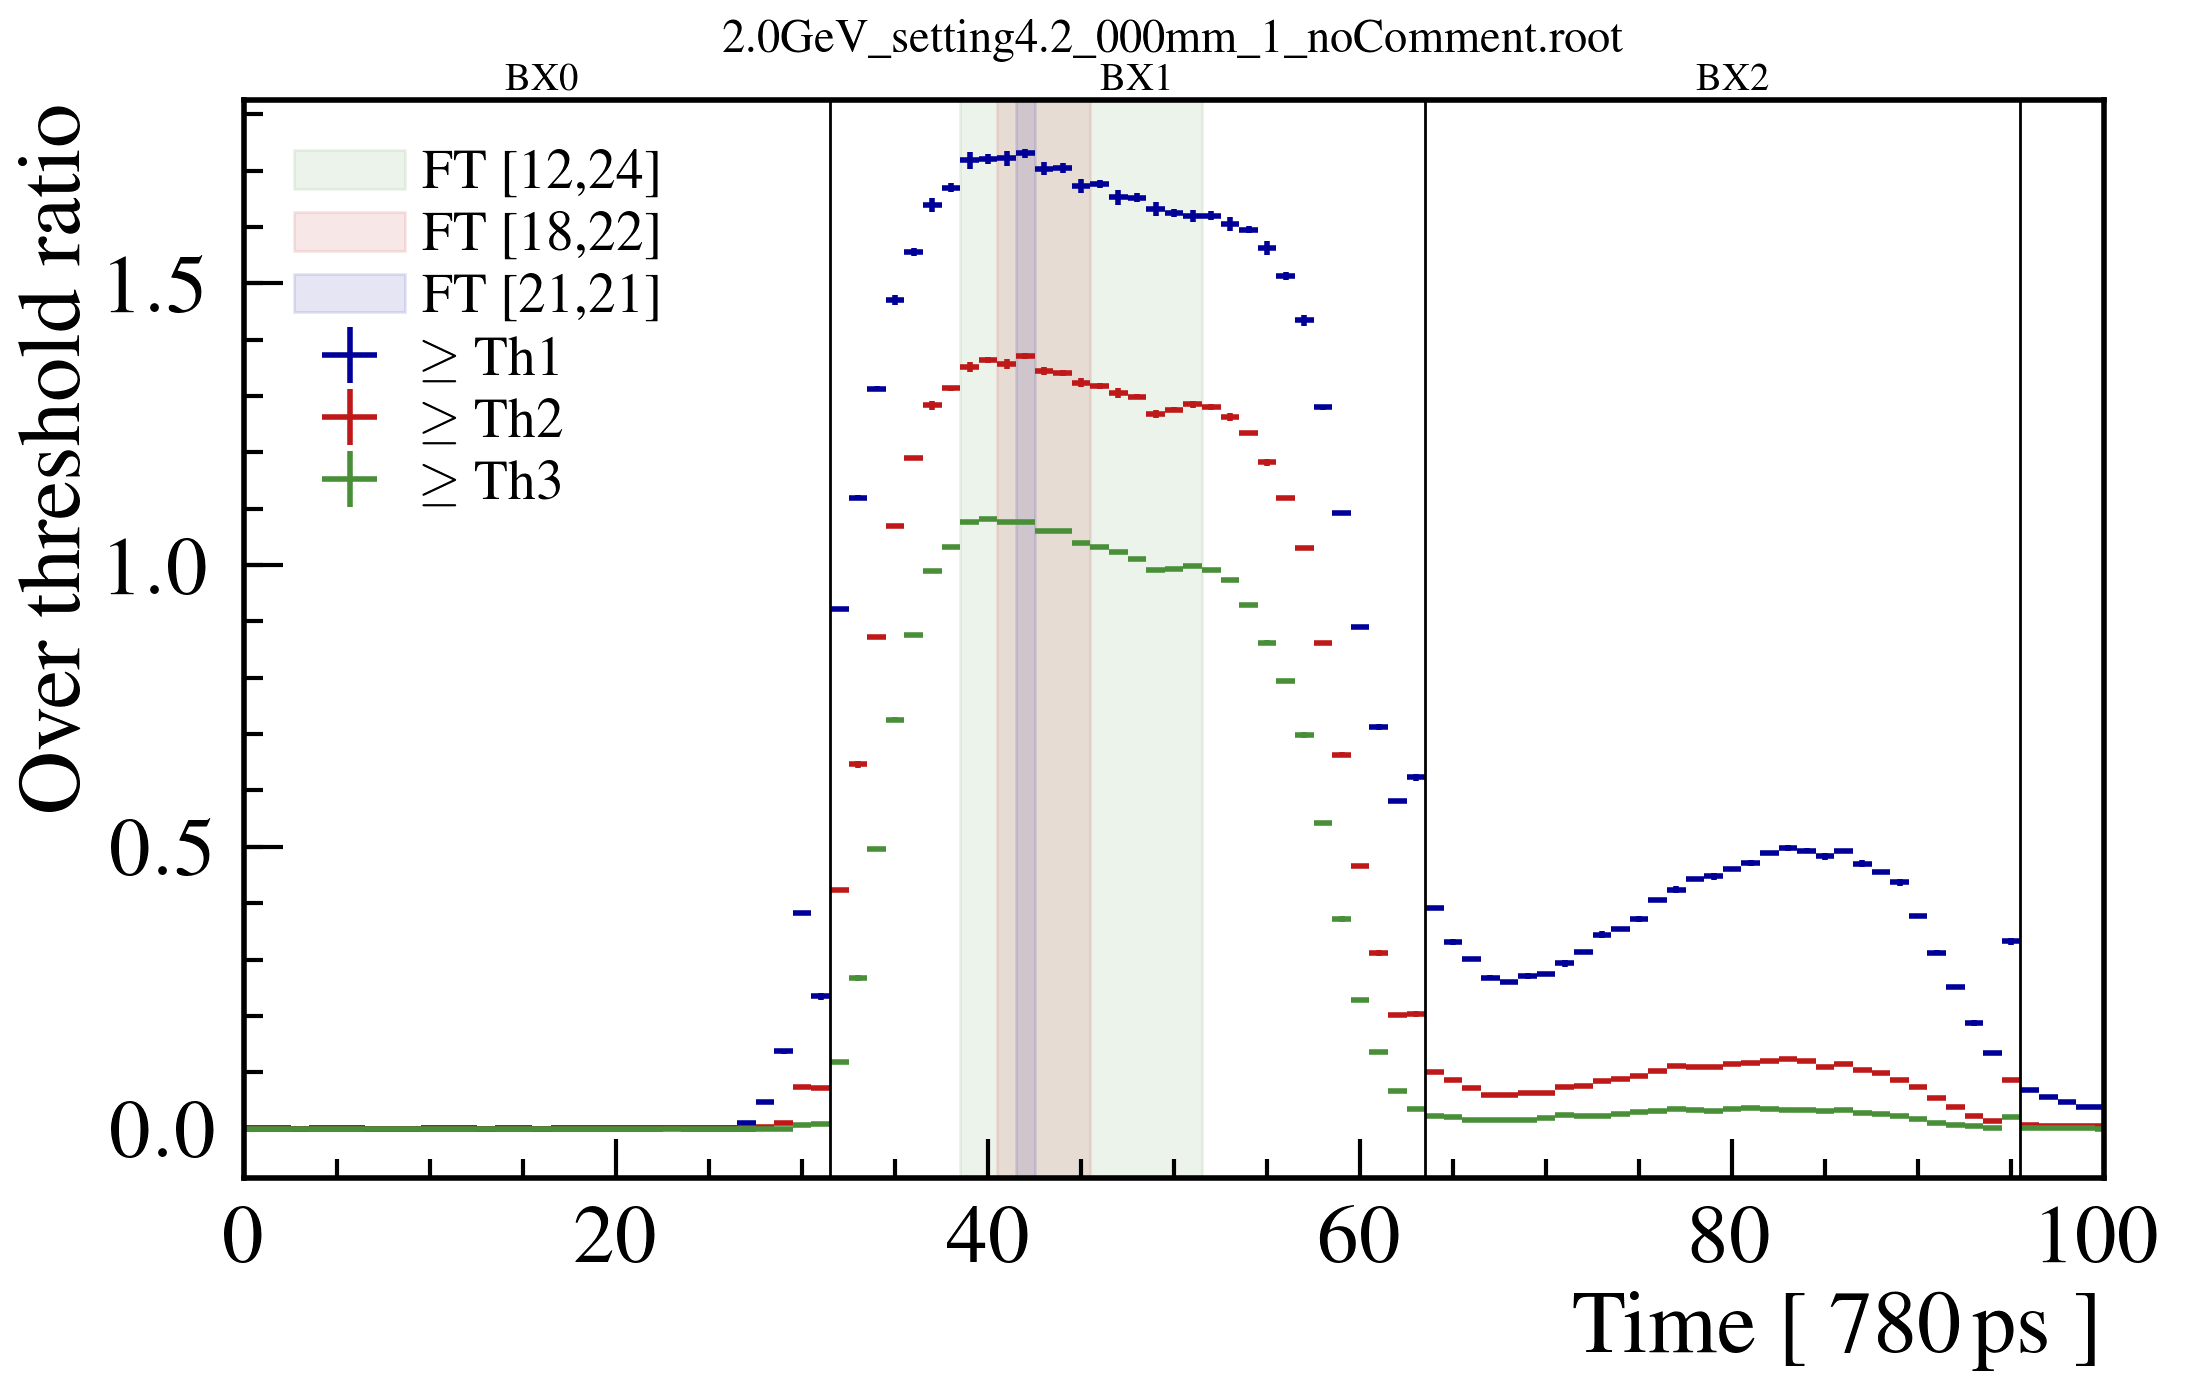

 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79
 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
 59 60]


 58 59]


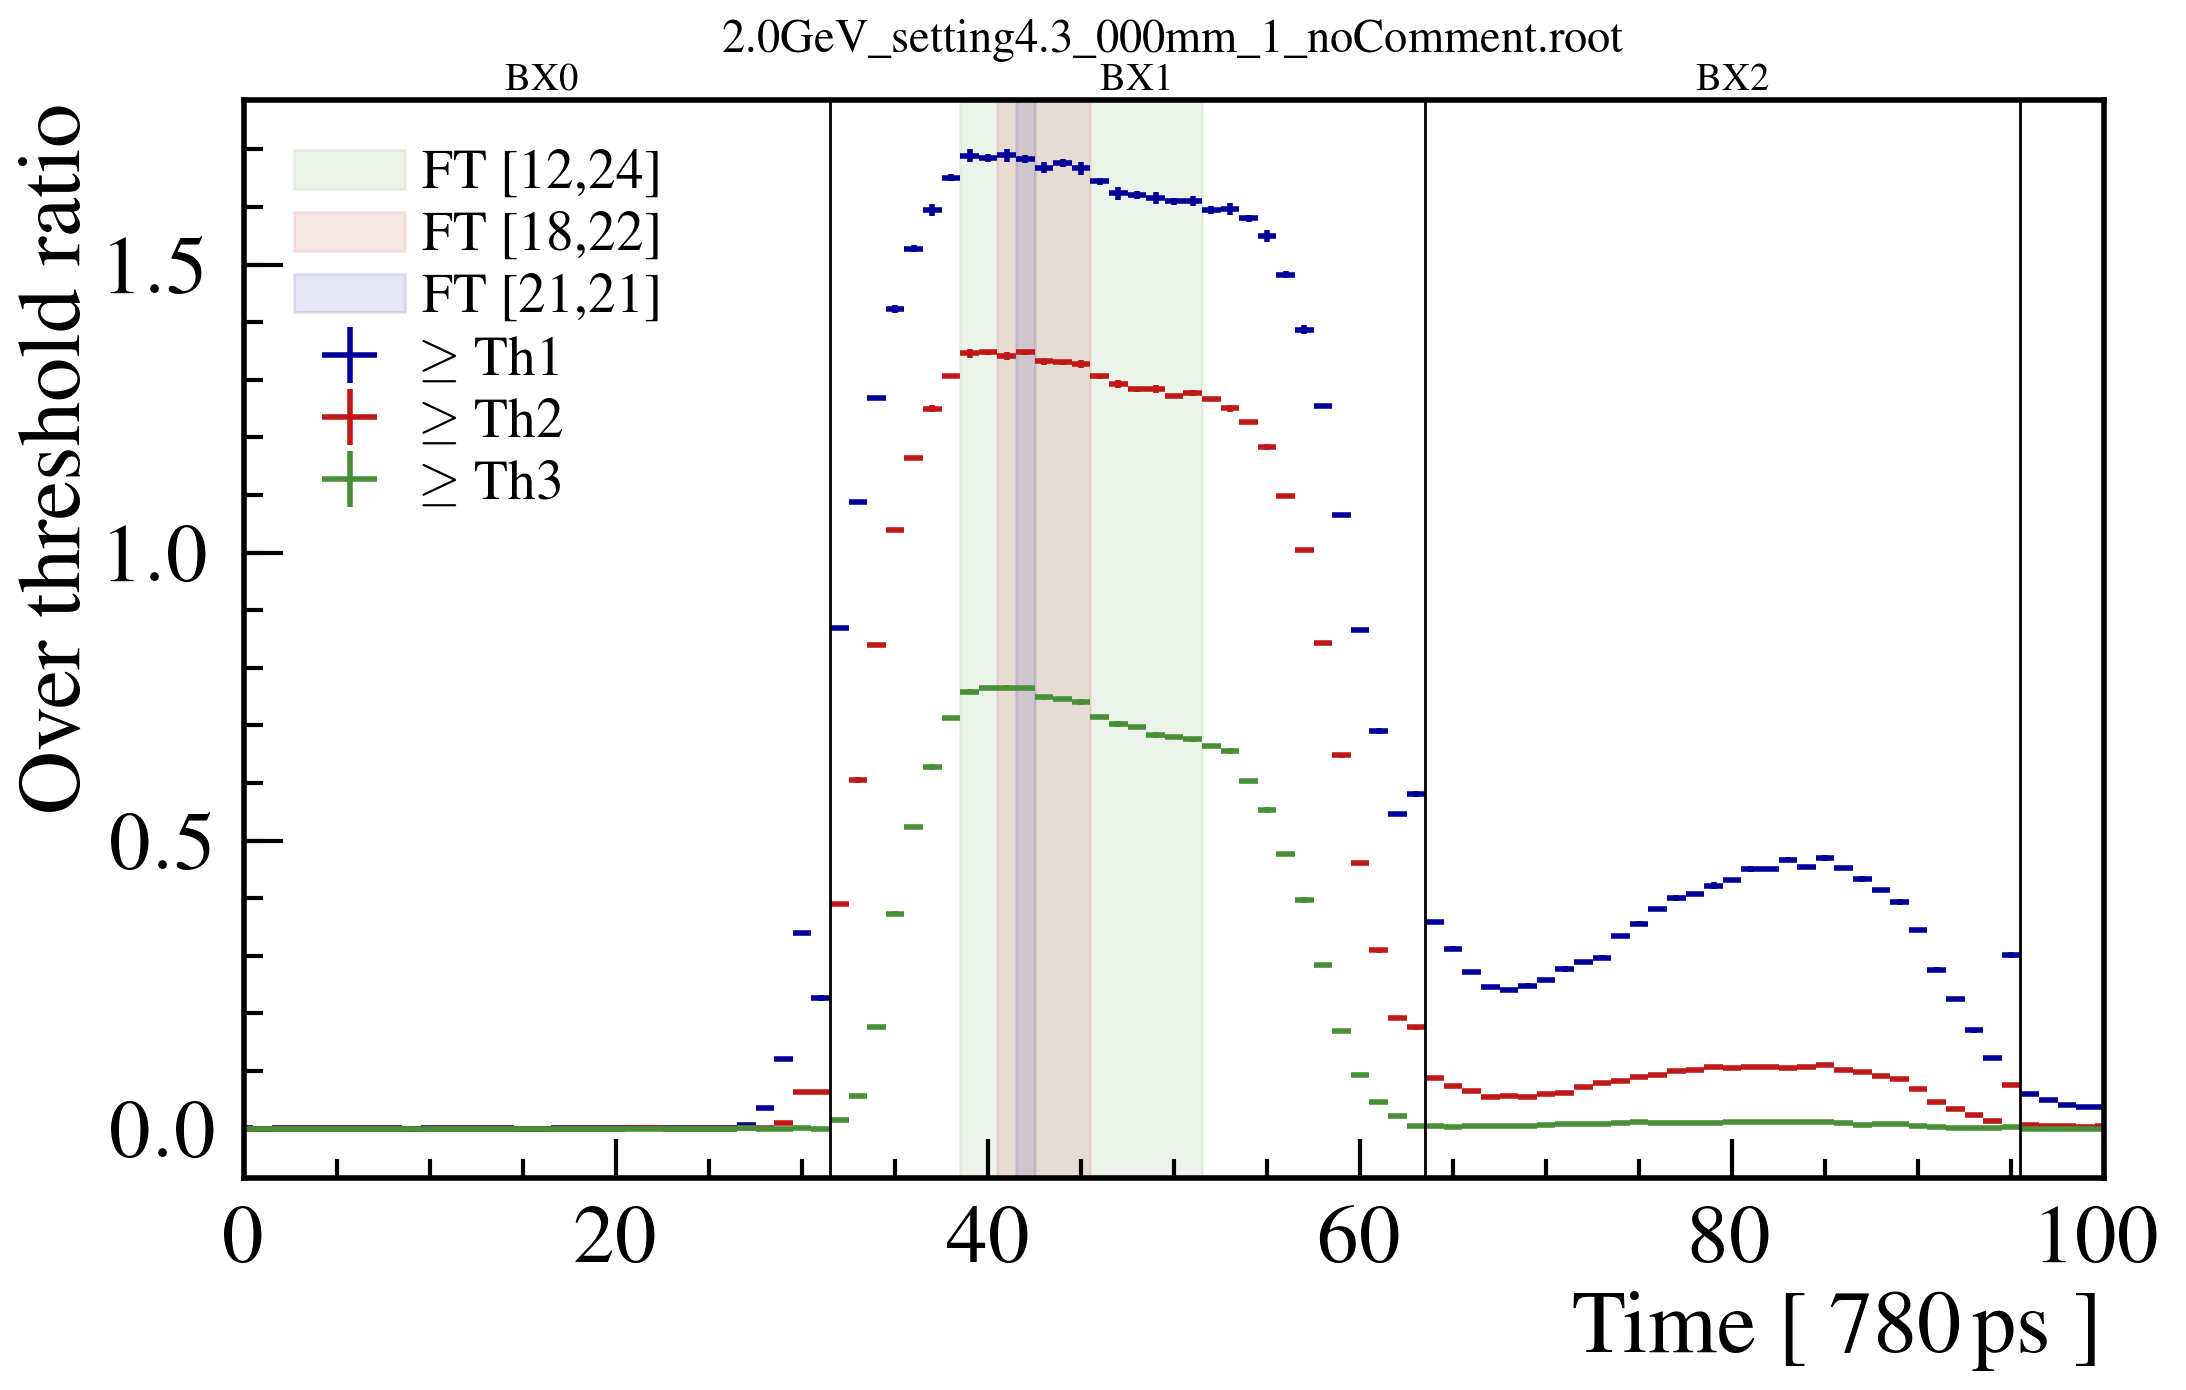

In [54]:
filename = "Plots/Signalshape/Aggregated.pdf"
channels = range(64)

finetiming_selections = [ (12, 24, "gcgreen"), (18, 22, "gcred"), (21,21, "gcblue")]

STUDENT.ensure_dir(os.path.dirname(filename))
pp = PdfPages(filename)

for index, row in DF_selected_files.iterrows():
    DF = row.loc["Dataframe"]
    plt.figure(figsize=(12,7))
    #plt.axvspan(calc_time(1, 14), calc_time(1, 18), facecolor="gcorange", alpha=0.3, label="Selection")
    for Th in [1,2,3]:
        pacific_signal, time, errlow, errup = TB.signalshape(DF["BXing"], DF["Finetiming"], 
                                                             DF[["Ch_{}".format(ch) for ch in channels]].values, Th)
        dpl.errorbar(np.asarray(time[:-1]), pacific_signal, xerr=0.5, yerr=[errlow,errup], fmt=".", ms=0, 
                     label="$\geq$ Th{}".format(Th))
        
    for finetiming_sel in finetiming_selections:
        time = ( TB.calc_time(1, finetiming_sel[0]-0.5), TB.calc_time(1, finetiming_sel[1]+0.5) )
        plt.axvspan(time[0], time[1], alpha=0.1, label="FT [{},{}]".format(finetiming_sel[0], finetiming_sel[1]),
                   color=finetiming_sel[2])

    plt.xlim(0,100)
    TB.plot_BX_overlay()
    plt.legend(fontsize=20)

    dpl.xlabel(r"Time [ $\SI{780}{ps}$ ]")
    dpl.ylabel("Over threshold ratio")
    plt.title(row["Filename_short"].replace("_", "\_"), y=1.03)
    pp.savefig()
    plt.show()
    plt.close()
    
pp.close()

# Plot Single-Channel Signalshapes

In [62]:
folder = "Plots/Signalshape/"
channels = range(64)

STUDENT.ensure_dir(folder)

for index, row in DF_selected_files.iterrows():
    DF = row.loc["Dataframe"]
    filename = row.loc["Filename_short"]
    saveto = folder+filename.replace(".root", ".pdf")
    pp = PdfPages(saveto)
    print("Writing ", saveto)
    
    plt.figure(figsize=(12,7))
    for ch in channels:
        if ch % 10 == 0:
            print("Channel ", ch)
        
        for Th in [1,2,3]:
            pacific_signal, time, errlow, errup = TB.signalshape(DF["BXing"], DF["Finetiming"], 
                                                                 DF["Ch_{}".format(ch)].values, Th)
            dpl.errorbar(np.asarray(time[:-1]), pacific_signal, xerr=0.5, yerr=[errlow,errup], fmt=".", ms=0, 
                         label="$\geq$ Th{}".format(Th))

        plt.xlim(0,100)
        TB.plot_BX_overlay()
        plt.legend(fontsize=20)

        dpl.xlabel(r"Time [ $\SI{780}{ps}$ ]")
        dpl.ylabel("Over threshold ratio")
        plt.title("Channel {}".format(ch), y=1.03)
        pp.savefig()
        plt.close()
    
    pp.close()

Writing  Plots/Signalshape/2.0GeV_setting4.1_000mm_1_noComment.pdf
Channel  0
Channel  10
Channel  20
Channel  30
Channel  40
Channel  50
Channel  60
Writing  Plots/Signalshape/2.0GeV_setting4.2_000mm_1_noComment.pdf
Channel  0
Channel  10
Channel  20
Channel  30
Channel  40
Channel  50
Channel  60
Writing  Plots/Signalshape/2.0GeV_setting4.3_000mm_1_noComment.pdf
Channel  0
Channel  10
Channel  20
Channel  30
Channel  40
Channel  50
Channel  60


# Plot over threshold events vs. channels for even and odd timestamps

In [74]:
selection = "Finetiming >= 12 and Finetiming <= 24 and BXing == 1"

filename = "Plots/Signalshape/Overthreshold_even_odd.pdf"
channels = range(64)

STUDENT.ensure_dir(os.path.dirname(filename))
pp = PdfPages(filename)

colors = ["gcblue", "gcred"]  #Even <-> Odd
thcolors = ["gcblue", "gcred", "gcgreen"]  #For the total plot
for index, row in DF_selected_files.iterrows():
    DF = row.loc["Dataframe"]
    DF_sel = DF.query(selection)
    filename = row["Filename_short"]
    print(filename)
    for order, orderfunc in [ ("SiPM", lambda x: x), ("ASIC", TB.SiPM2ASIC) ]:
        ftot, ax = dpl.subplots(1, figsize=(12,10))  #All comparators in one plot
        f, thplots = dpl.subplots(3, sharex=True, figsize=(12,20))   #One subplot for each comparator
        for Th in [1,2,3]:
            for i, evenodd in enumerate(["Even", "Odd"]):
                DF_evenodd = DF_sel[ DF_sel["Timestamp"] % 2 == i ]
                ratio, chans, ratio_errlow, ratio_errup = TB.overthreshold_vs_channels(
                                                             DF_evenodd[["Ch_{}".format(ch) for ch in channels]].values, 
                                                             Th)
                chans = orderfunc(np.asarray(chans))
                ratio *= len(DF_evenodd)
                ratio_errlow *= len(DF_evenodd)
                ratio_errup *= len(DF_evenodd)
                thplots[Th-1].errorbar(chans, ratio, xerr=0.5, yerr=[ratio_errlow, ratio_errup], fmt=".", ms=0, 
                         label="$\geq$ Th{}, {}".format(Th, evenodd), color=colors[i])
                
                #Trackhit positions
                #trackhits,_ = np.histogram(DF_evenodd["TrackHit_Ch"], np.arange(channels[0]-0.5,channels[-1]+1,1))
                #thplots[Th-1].bar(chans, trackhits, edgecolor=colors[i], facecolor="none", 
                #                  label=r"Track hits, "+evenodd, alpha=0.5, lw=2)

                ax.errorbar(chans, ratio, xerr=0.5, yerr=[ratio_errlow, ratio_errup], fmt="o" if i == 0 else "^",
                           ms=5, label="$\geq$ Th{}, {}".format(Th, evenodd), color=thcolors[Th-1])
                

            thplots[Th-1].legend(fontsize=18)
            thplots[Th-1].set_ylabel("Entries")
            thplots[Th-1].set_xlabel(order+" Channel")


        thplots[0].set_title("{}\n{} ordering\n{}".format(filename.replace("_", "\_"), order, selection))
        f.subplots_adjust(hspace=0)
        plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
        ax.legend(fontsize=18)
        ax.set_ylabel("Entries")
        ax.set_xlabel(order+" Channel")
        ax.set_title("{}\n{} ordering\n{}".format(filename.replace("_", "\_"), order, selection))
        pp.savefig(f)
        plt.close(f)
        pp.savefig(ftot)
        plt.close(ftot)
    
print("DONE")
pp.close()

2.0GeV_setting4.2_000mm_1_noComment.root
2.0GeV_setting4.1_000mm_1_noComment.root
2.0GeV_setting4.3_000mm_1_noComment.root
DONE


# Plot ratio of events above threshold for 2.5 and 1.5 pe

In [153]:
selection = "Finetiming >= 12 and Finetiming <= 24 and BXing == 1"

filename = "Plots/Signalshape/Ratio_25_15pes.pdf"
channels = range(64)

STUDENT.ensure_dir(os.path.dirname(filename))
pp = PdfPages(filename)

colors = ["gcblue", "gcred"]  #Even <-> Odd
thcolors = ["gcblue", "gcred", "gcgreen"]  #For the total plot
for order, orderfunc in [ ("SiPM", lambda x: x), ("ASIC", TB.SiPM2ASIC) ]:
    print(order)
    for i, evenodd in enumerate(["Even", "Odd"]):
        print(evenodd)
        f, ax = dpl.subplots(1, figsize=(12,10))  #One plot per order and even-odd combination
        for index, row in DF_selected_files.iterrows():
            DF = row.loc["Dataframe"]
            DF_sel = DF.query(selection)
            DF_evenodd = DF_sel[ DF_sel["Timestamp"] % 2 == i ]

            filename = row["Filename_short"]
            th_setting = row["ThSetting"]
            #Choose Ths correspdonding to 1.5 and 2.5 pe depending on ThSetting
            if th_setting == 2 or th_setting == 3:
                Ths = [1, 2]
            elif th_setting == 1:
                Ths = [2, 3]
            else:
                raise ValuError("Wrong thsetting {}".format(th_setting))
            print(filename)
            #Only passing 15
            entries_over_15, chans, err_15 = TB.overthreshold_vs_channels(
                                                DF_evenodd[["Ch_{}".format(ch) for ch in channels]].values, 
                                                Ths[0], mode="equal", return_raw=True)
            entries_over_15_werr = unumpy.uarray(entries_over_15, err_15)
            #At least passing 25
            entries_over_25, chans, err_25 = TB.overthreshold_vs_channels(
                                                DF_evenodd[["Ch_{}".format(ch) for ch in channels]].values, 
                                                Ths[1], mode="ge", return_raw=True)
            entries_over_25_werr = unumpy.uarray(entries_over_25, err_25)
            chans = orderfunc(np.asarray(chans))

            #Ratio of events passing 2.5pe of all that pass 1.5pe for individual channels
            #Add small number to avoid division through 0
            ratio = entries_over_25_werr / (entries_over_15_werr + entries_over_25_werr + 0.0001) 
            #Ratio for all channels together
            ratio_mean = np.sum(entries_over_25_werr) / (np.sum(entries_over_15_werr) + np.sum(entries_over_25_werr))


            ax.errorbar(chans, unumpy.nominal_values(ratio), xerr=0.5, yerr=unumpy.std_devs(ratio), fmt=".",
                        ms=0, label="ThSetting {}".format(th_setting), 
                        color=thcolors[th_setting-1])

            ax.plot([-10, -1], 2*[ratio_mean.nominal_value], color=thcolors[th_setting-1])


        ax.plot([], [], "k-", label="Mean")
        ax.legend(fontsize=18)
        ax.set_ylabel(r"Ratio $\ge2.5\,\text{{pe}}/\ge1.5\,\text{{pe}}$")
        ax.set_xlabel(order+" Channel")
        ax.set_title("{} Timestamps\n{} ordering\n{}".format(evenodd, order, selection))
        ax.set_ylim(0.65, ax.get_ylim()[1])
        ax.set_xlim(-10, 63.5)
        ax.grid(which="both", axis="x")
        pp.savefig(f)
        plt.close(f)

pp.close()
print("Saved to {}".format(filename))

SiPM
Even
2.0GeV_setting4.2_000mm_1_noComment.root
2.0GeV_setting4.1_000mm_1_noComment.root
2.0GeV_setting4.3_000mm_1_noComment.root
Odd
2.0GeV_setting4.2_000mm_1_noComment.root
2.0GeV_setting4.1_000mm_1_noComment.root
2.0GeV_setting4.3_000mm_1_noComment.root
ASIC
Even
2.0GeV_setting4.2_000mm_1_noComment.root
2.0GeV_setting4.1_000mm_1_noComment.root
2.0GeV_setting4.3_000mm_1_noComment.root
Odd
2.0GeV_setting4.2_000mm_1_noComment.root
2.0GeV_setting4.1_000mm_1_noComment.root
2.0GeV_setting4.3_000mm_1_noComment.root
Saved to 2.0GeV_setting4.3_000mm_1_noComment.root
